# Data File to Final Output

### File path here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Enter File Path here:
#file_path = "data_files/prediction_results_30_xxx.dat"
#file_path = "data_files/prediction_results_50.dat"

file_path = "data_files/prediction_results_40_final.dat"

In [2]:
# def process_data_file(input_path, output_path):
#     # Read the entire file content
#     with open(input_path, 'r') as file:
#         lines = file.readlines()
    
#     # Process the file line by line
#     processed_lines = []
#     for i, line in enumerate(lines):
#         # Keep the first three lines unchanged
#         if i < 3:
#             processed_lines.append(line)
#             continue
        
#         # Process lines starting from line 4 (index 3)
#         parts = line.split()
        
#         # Check if the line has at least 6 columns and columns 4-6 can be converted to float
#         if len(parts) >= 6:
#             try:
#                 # Try to convert columns 4-6 to float for rounding
#                 for j in range(3, 6):
#                     if j < len(parts):
#                         parts[j] = f"{float(parts[j]):.3f}"
                
#                 # Reconstruct the line with rounded values
#                 processed_line = '\t'.join(parts) + '\n'
#                 processed_lines.append(processed_line)
#             except ValueError:
#                 # If conversion fails, keep the original line
#                 processed_lines.append(line)
#         else:
#             # If the line doesn't have enough columns, keep it as is
#             processed_lines.append(line)
    
#     # Write the processed content to the output file
#     with open(output_path, 'w') as file:
#         file.writelines(processed_lines)
    
#     print(f"File processed successfully. Output saved to {output_path}")

# # File paths
# input_file_path = "data_files/prediction_results_40.dat"
# output_file_path = "data_files/prediction_results_40_new.dat"

# # Process the file
# process_data_file(input_file_path, output_file_path)

### Extract Data From Dat File - Extract A, b, and F

In [3]:

# Helper Functions:

def generate_x_axis(triangles, y_length): 
    total_min = sum(tri[0] for tri in triangles)
    total_max = sum(tri[2] for tri in triangles)
    x = np.linspace(total_min, total_max, y_length)
    x /= num_experts
    return x  # Calculate total min and max based on start and end points across all triangles

def triangle_function(tri, num_points=1250):
    min_val, apex, max_val = tri
    x = np.linspace(min_val, max_val, num_points)
    y = np.maximum(0, np.minimum((x - min_val) / (apex - min_val), (max_val - x) / (max_val - apex)))
    return x, y  # Defines the triangle function

def cumulative_convolve_triangles(triangle_list, num_points=1250):
    if not triangle_list:
        return None, None, None  # In case of empty triangle list
    
    if len(triangle_list) == 1:
        #print('1 encountered')
        x, y = triangle_function(triangle_list[0], num_points=num_points)
        mode_index = np.argmax(y)
        mode_x = x[mode_index]
        y /= np.sum(y) 
        return x, y, mode_x

    # Start with the first triangle
    _, y = triangle_function(triangle_list[0], num_points=num_points)
    total_min = triangle_list[0][0]
    total_max = triangle_list[0][2]
    
    # Convolve with each subsequent triangle
    for tri in triangle_list[1:]:
        _, y2 = triangle_function(tri, num_points=num_points)
        y = np.convolve(y, y2, mode='full')
        
        # Update the range after each convolution
        total_min += tri[0]
        total_max += tri[2]

    y /= np.sum(y)    
    x = np.linspace(total_min, total_max, len(y))  # Adjust x-axis for full range

    # Determine the mode (peak location) after cumulative convolution
    mode_index = np.argmax(y)
    mode_x = x[mode_index]
    return x, y, mode_x



# Main Algorithm
with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        if i == 0:
            data = line.split()
            num_imgs = int(data[0])
            num_experts = int(data[1])
            num_links = int(data[2])
            A_matrix = np.zeros((num_imgs, num_experts))
            F_matrix = [[None for _ in range(num_experts)] for _ in range(num_imgs)]
        
        if i == 2:
            b_array = np.array(line.split()).astype(np.float64)
        
        # From row 4 until the end
        if i >= 3 and i <= (num_links + 2):  # From row 4 until the end
            
            # Split the Data
            data = line.split()

            # Assemble relevant triangle from current row
            start = float(data[3])
            apex = float(data[4])
            end = float(data[5])
            triangle = [start, apex, end]
                      
            # Choose the correct Row for Matrices A and F
            row = (i - 3) // num_experts        

            # Choose the correct column for the given row
            col = int(data[2])
            
            # Initialize Triangle List to 0
            if (i - 3) % num_experts == 0:     
                triangles_dict = {j: [] for j in range(num_experts)}  # Dictionary to store triangles by index
            
            # Append Triangle to corresponding list in the dictionary
            triangles_dict[col].append(triangle)  

            # Perform Convolutions and store to row and column
            if (i - 3 + 1) % num_experts == 0:
                for col_index in range(num_experts):
                    # Get triangles for the current column index
                    triangle_list = triangles_dict[col_index]
                    
                    if triangle_list:  # Only perform convolution if there are triangles
                        x, y, mode_x = cumulative_convolve_triangles(triangle_list)

                        if mode_x is not None:  # Check if mode_x is not None
                            A_matrix[row, col_index] = mode_x/ num_experts                        
                            #F_matrix[row][col_index] = y
                            F_matrix[row][col_index] = (x/num_experts, y)  # Store x, y as a tuple in F_matrix

# Print the rounded matrix
print('Sum of b array', np.sum(b_array))
print(b_array)
print()
print()
print(np.round(A_matrix, 4))

# Plot a sample convolution from F_matrix with dynamically generated x-axis
sample_row = 1
sample_col = 0



# Check if the specific entry in F_matrix is not None
if F_matrix[sample_row][sample_col] is not None:
    sample_x, sample_y = F_matrix[sample_row][sample_col]  # Unpack x and y directly
    
    plt.plot(sample_x, sample_y)
    plt.title(f'Sample Convolution from F_matrix[{sample_row}][{sample_col}]')
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    plt.show()


Sum of b array 1.0
[0.   0.02 0.14 0.01 0.06 0.   0.   0.69 0.   0.08]


[[0.     0.     0.     0.     0.     0.     0.     0.     0.2935 0.    ]
 [0.     0.     0.     0.0955 0.     0.3568 0.0098 0.     0.0257 0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0167 0.     0.4111]
 [0.     0.     0.0092 0.0798 0.     0.3067 0.     0.     0.0454 0.    ]
 [0.     0.7518 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0112 0.54   0.     0.     0.     0.     0.     0.    ]
 [0.     0.0207 0.     0.     0.     0.     0.     0.1387 0.     0.1856]
 [0.     0.     0.     0.     0.3052 0.     0.0135 0.     0.     0.063 ]
 [0.     0.     0.     0.     0.4764 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0095 0.     0.4308 0.     0.     0.    ]
 [0.     0.     0.     0.0468 0.     0.2845 0.0866 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.5449 0.     0.     0.    ]
 [0.     0.     0.0225 0.0262 0.     0.     0.0148 

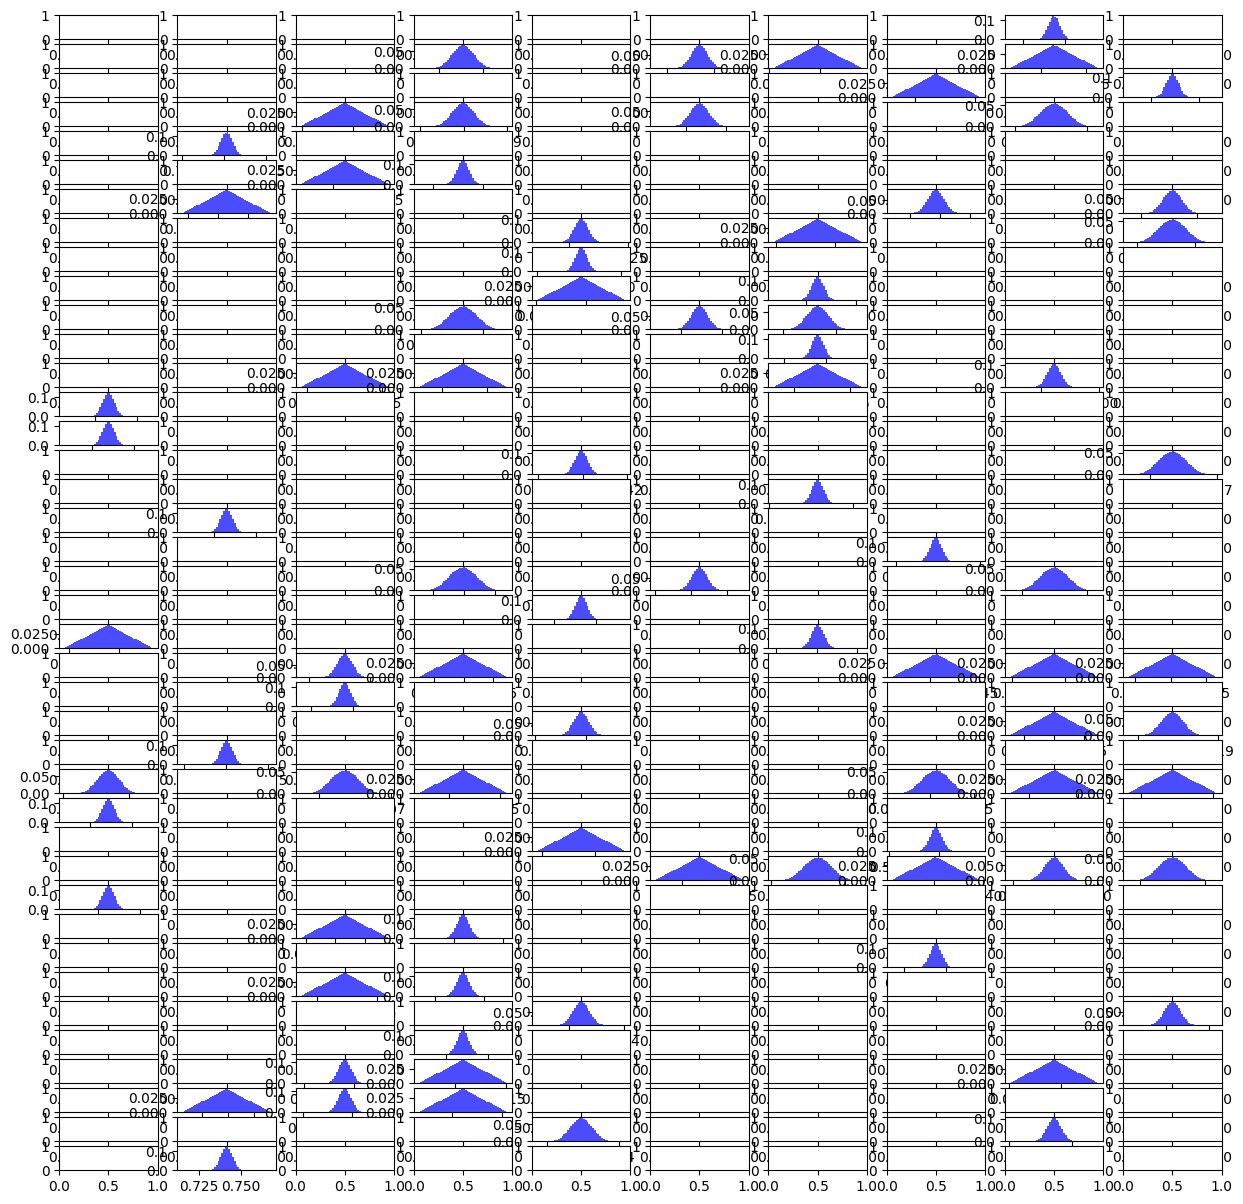

In [4]:
fig, axes = plt.subplots(nrows=len(F_matrix), ncols=len(F_matrix[0]), figsize=(15, 15))

for i in range(len(F_matrix)):
    for j in range(len(F_matrix[i])):
        if F_matrix[i][j] is not None:  # Check if the entry is not None
            x, y = F_matrix[i][j]  # Unpack x and y from F_matrix
            axes[i, j].hist(x, weights=y, bins=50, alpha=0.7, color='blue')  # Use weights for probability distribution

plt.show()


#### Sampling from F Example

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Sample from F Function.
def sample_from_F_matrix(F_matrix):
    F_sampled = np.zeros((len(F_matrix), len(F_matrix[0])), dtype=float)
    
    for i in range(len(F_matrix)):
        for j in range(len(F_matrix[i])):
            if F_matrix[i][j] is not None:
                x, y = F_matrix[i][j]  # Unpack x and y
                
                # Sample from x using the probability distribution y / np.sum(y)
                sampled_values = np.random.choice(x, 1, p=y / np.sum(y))
                F_sampled[i, j] = sampled_values
    return F_sampled


# Sample from F_matrix
F_sampled = sample_from_F_matrix(F_matrix)

# Print the rounded sampled matrix
print("F_sampled:")
print(np.round(F_sampled, 4))

F_sampled:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.2948 0.    ]
 [0.     0.     0.     0.0947 0.     0.3551 0.0098 0.     0.025  0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.0166 0.     0.4137]
 [0.     0.     0.0109 0.0791 0.     0.3074 0.     0.     0.0457 0.    ]
 [0.     0.7501 0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.0097 0.5341 0.     0.     0.     0.     0.     0.    ]
 [0.     0.0209 0.     0.     0.     0.     0.     0.1432 0.     0.1821]
 [0.     0.     0.     0.     0.3055 0.     0.0141 0.     0.     0.0619]
 [0.     0.     0.     0.     0.475  0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.0098 0.     0.4312 0.     0.     0.    ]
 [0.     0.     0.     0.0447 0.     0.285  0.0848 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.5463 0.     0.     0.    ]
 [0.     0.     0.024  0.0254 0.     0.     0.0154 0.     0.1797 0.    ]
 [0.6764 0.     0.     0.     0.     0. 

/var/folders/nh/h2lw4fwd2f36n5kbgnd30wy80000gn/T/ipykernel_92359/2307554527.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F_sampled[i, j] = sampled_values


##  Define methods for Vertex Finding

This requires installing some libraries such as cdd.  

https://pypi.org/project/pycddlib/  

https://pycddlib.readthedocs.io/en/latest/quickstart.html

you may have to run this command: pip install pycddlib-standalone

In [6]:
import numpy as np
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt
import cdd
import numpy as np

def linearizewithscipy(A,b):

    x_len = A.shape[1]

    # Objective function: Minimize t
    c = np.zeros(x_len + 1)  # n_vars for x and 1 for t
    c[-1] = 1  # Coefficient of t in the objective function

    # Creating Augmented A and Augmented b matrix
    A_ub = np.hstack([A, -np.zeros((A.shape[0], 1))])
    A_ub = np.vstack( [A_ub, np.hstack ([-A, -np.ones((A.shape[0], 1))] )])
#   A_ub = np.vstack( [A_ub, np.hstack ([-A, -np.ones((A.shape[0]-1, 1)),0] )])

    b_ub = np.hstack([b, -b])


    # Additional constraints: sum(x) <= 1
    A_eq = np.zeros((1, x_len + 1))
    A_eq[0, :x_len] = 1
    b_eq = [1]

    # Bounds for x and t
    bounds = [(0, 1)] * x_len + [(0, None)]  # x in [0, 1] and t in [0, inf]

    # Solving the linear programming problem
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    # Extracting the solution
    x = res.x[:-1]
    t = res.x[-1] # Sup norm

    # Testing Results
    b_found = A.dot(x)
    bdifference = b - b_found
    score = bdifference
    norm2 = np.linalg.norm(bdifference, 2)
    print("Optimal value of objective function:", t)
    print("Optimal solution x:", x)
    print()
    print('b desired', b)
    print('b found  ', np.round(b_found,3))
    print()
    print('difference', np.round(score,3))

    print('L1 norm is:', t)
    print("L2 norm is: ", norm2)

    return t, x, b_found, bdifference 




def montecarlo(array, b_desired):

    # Helper functions
    def initialize_vector():
        k = np.random.randint(5, 20) # Change
        initial_phi = np.zeros(len(array[0]))
        random_indices = np.random.choice(len(initial_phi), k, replace=False)
        numbers = [np.random.uniform(0, 0.1)]
        random_max = 0.05  
        for _ in range(k - 1):
            numbers.append(np.random.uniform(0, random_max - np.sum(numbers)))
        initial_phi[random_indices] = numbers
        return initial_phi

    def calculate_error(phi, penal_mult):
        computed_b = np.dot(array, phi)
        diff = b_desired - computed_b
        penalty1 = -100 * np.sum(diff[diff < 0])
        penalty2 = 0  # .1 * np.sum(diff[diff > 0])  # L1 penalty (currently unused)
        penalty3 = 2 * np.max(diff)
        penalty4 = penal_mult * (1 - sum(phi)) ** 2
        penalties = penalty1 + penalty3 + penalty4 + penalty2
        return penalties

    # Parameters
    T = 10e-3
    T_now = T
    T_min = 3*10e-9
    alpha = 0.55
    num_iterations = 100_000
    penal_mult = 0.1
    step_size = 0.25

    # Initializations
    iter = 0
    counter = []
    error_values = []
    best_values_all = []
    best_phi = np.zeros(len(array[0]))
    best_error = np.inf
    current_phi = np.zeros(len(array[0]))#initialize_vector()
    current_error = np.inf

    # Monte Carlo simulation
    while T > T_min:
        
        if T_now > T:
            print('T',np.round(T,7))
            T_now = T

        for _ in range(num_iterations):
            iter += 1

            # Perturb phi
            new_phi = current_phi.copy()
            index = np.random.randint(0, len(new_phi))
            change = np.random.uniform(-step_size, step_size)
            new_phi[index] += change
            new_phi[new_phi < 0] = 0


            # Skip if sum constraint is violated
            if np.sum(new_phi) > 1:
                continue

            # Calculate new error
            new_error = calculate_error(new_phi, penal_mult)

            # Acceptance criterion
            if new_error < current_error or np.random.uniform() < np.exp((current_error - new_error) / T):
                current_phi = new_phi
                current_error = new_error
                counter.append(iter)
                error_values.append(current_error / 2)
                if new_error < best_error:
                    best_error = new_error
                    best_phi = new_phi
                    best_values_all.append(best_phi)

        # Cooling schedule
        T *= alpha
        step_size *= alpha**(0.5)
        penal_mult *= 1.01

    # Visualization (optional)
    plt.plot(counter[600:], error_values[600:])
    plt.grid()
    plt.show()

    # Results
    b_found = array.dot(best_phi)
    score = b_desired - b_found

    # Print results (optional)
    print('b desired', np.round(b_desired,4))
    print('b found', np.round(b_found, 4))
    print()
    print('difference', np.round(score, 4))
    print("Sup Norm is", np.max(score))
    print("L2 norm is", np.linalg.norm(score, 2))
    print()
    print('best_phi',np.round(best_phi,3))

    return counter, error_values, best_phi, b_found, score


def vertexcddlist(A, b):
    # Number of variables
    num_vars = A.shape[1]
    
    # Step 1: Add non-negativity constraints
    negative_identity = -np.eye(num_vars)
    
    # Step 2: Add sum constraint
    sum_constraint = np.ones((1, num_vars))
    
    # Stack constraints
    A = np.vstack((A, sum_constraint, negative_identity))
    
    #print('Debugging b', b, b.shape)
    # Step 4: Update b vector
    b = np.hstack((b, 1, np.zeros(num_vars)))  # Append 1 for the sum constraint and zeros for non-negativity
    
    # Step 5: Create inequality representation
    array = np.hstack((b.reshape(-1, 1), -A))
    
    # Create a matrix from the array using inequality representation
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    cdd.matrix_canonicalize(mat)

    # Construct a polyhedron from the matrix
    poly = cdd.polyhedron_from_matrix(mat)

    # Remove redundant constraints
    # poly.remove_redundant()  # Uncomment if needed

    # Copy the generators of the polyhedron
    gen = cdd.copy_generators(poly)

    # Extract the solutions (generators) and ignore the first column
    solutions = np.array(gen.array)
    solutions = solutions[:, 1:]  # Ignore the first column (b values)
    print('Vertices found:', solutions.shape[0], '    Dimension of phi', solutions.shape[1])

    return solutions


def find_supnorm_vertices(A,b,solutions):
    best_vertices=[]
    best_sup_norm = np.inf
    for boogers in solutions:
        
        sup_norm = np.max((b-A@boogers ))

        if sup_norm == best_sup_norm:
            best_vertices.append(boogers)
        
        if sup_norm < best_sup_norm:
            best_vertices=[]
            best_sup_norm = sup_norm
            best_vertices.append(boogers)

    best_vertices = np.array(best_vertices)

    print()
    print('Sup norm', best_sup_norm)
    print('number of best points',(best_vertices.shape[0]))
    print('Example of Best Vertex', best_vertices[0])
    print("Number of active constraints", A.shape[0] +(A.shape[1]-np.count_nonzero( best_vertices[0])))
    print('Sum of example phi',np.sum(best_vertices[0]))
    
    

    return best_vertices, best_sup_norm




# A and b are defined above

def vertexcddlist2(A, b):
    # Number of variables
    num_vars = A.shape[1]
    
    # Step 1: Add non-negativity constraints
    negative_identity = -np.eye(num_vars)
    
    # Step 2: Add sum constraint
    sum_constraint = np.ones((1, num_vars))
    sum_constraint[0, -1] = 0
    #print(sum_constraint)

    
    # Stack constraints
    A = np.vstack((A, sum_constraint, negative_identity))
    
    # Step 4: Update b vector
    b = np.hstack((b, 1, np.zeros(num_vars)))  # Append 1 for the sum constraint and zeros for non-negativity
    
    # Step 5: Create inequality representation
    array = np.hstack((b.reshape(-1, 1), -A))
    
    # Create a matrix from the array using inequality representation
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    cdd.matrix_canonicalize(mat)

    # Construct a polyhedron from the matrix
    poly = cdd.polyhedron_from_matrix(mat)

    # Remove redundant constraints
    #poly.remove_redundant()  # Uncomment if needed

    # Copy the generators of the polyhedron
    gen = cdd.copy_generators(poly)

    # Extract the solutions (generators) and ignore the first column
    solutions = np.array(gen.array)
    solutions = solutions[:, 1:]  # Ignore the first column (b values)
    print('Vertex Walk Complete')
#    print('Vertices found:', solutions.shape[0], ')
    print('Vertices found:', solutions.shape[0], '    Dimension of vertex', solutions.shape[1]-1)

    return solutions



def linear_reformulation(A,b):


    # Creating Augmented A and Augmented b matrix
    A_ub = np.hstack([A, -np.zeros((A.shape[0], 1))])
    A_ub = np.vstack( [A_ub, np.hstack ([-A, -np.ones((A.shape[0], 1))] )])# change this 0 to 1
    b_ub = np.hstack([b, -b])

    return A_ub, b_ub

# # import numpy as np
# def linear_reformulation(A, b, remove_redundant=True, epsilon=0.3):
#     """
#     Reformulate the linear system for sup norm minimization with redundancy removal.
    
#     Parameters:
#     A (numpy.ndarray): The constraint matrix
#     b (numpy.ndarray): The right-hand side vector
#     remove_redundant (bool): Whether to remove redundant constraints
#     epsilon (float): Tolerance for numerical comparisons
    
#     Returns:
#     tuple: (A_ub, b_ub) - The reformulated system
#     """
#     # Print the original dimensions
#     print(f"Original dimensions: A is {A.shape}, b is {len(b)}")
    
#     # Creating Augmented A and Augmented b matrix
#     A_ub = np.hstack([A, np.zeros((A.shape[0], 1))])  # Add a column of zeros
#     A_ub = np.vstack([A_ub, np.hstack([-A, -np.ones((A.shape[0], 1))])])  # Stack with -A and -1s
#     b_ub = np.hstack([b, -b])  # Stack b with -b
    
#     if remove_redundant:
#         # Get the initial count for reporting
#         initial_rows = A_ub.shape[0]
        
#         # Step 1: Remove duplicate constraints
#         # Round values to handle numerical precision issues
#         rounded_A = np.round(A_ub / epsilon) * epsilon
#         rounded_b = np.round(b_ub / epsilon) * epsilon
#         combined = np.hstack([rounded_A, rounded_b.reshape(-1, 1)])
        
#         # Find unique rows while preserving the original values
#         _, unique_indices = np.unique(combined, axis=0, return_index=True)
#         unique_indices = np.sort(unique_indices)  # Keep original order
#         A_ub = A_ub[unique_indices]
#         b_ub = b_ub[unique_indices]
        
#         # Step 2: Remove constraints that are always satisfied
#         # (where all A coefficients are zero and b >= 0)
#         zero_rows = np.all(np.abs(A_ub) < epsilon, axis=1)
#         always_satisfied = zero_rows & (b_ub >= -epsilon)
#         A_ub = A_ub[~always_satisfied]
#         b_ub = b_ub[~always_satisfied]
        
#         # Report the reduction
#         final_rows = A_ub.shape[0]
#         removed = initial_rows - final_rows
#         print(f"Removed {removed} redundant constraints ({100*removed/initial_rows:.1f}%)")
#         print(f"New dimensions: A_ub is {A_ub.shape}, b_ub is {len(b_ub)}")
    
#     return A_ub, b_ub


def find_supnorm_vertices2(A,b,solutions):

    best_vertices=[]
    best_sup_norm = np.inf
    for boogers in solutions:
    
        sup_norm = np.max((b-A@boogers ))

        if sup_norm == best_sup_norm:
            best_vertices.append(boogers)

        if sup_norm < best_sup_norm:
            best_vertices=[]
            best_sup_norm = sup_norm
            best_vertices.append(boogers)

    best_vertices = np.array(best_vertices)


    print()
    print('Sup norm', best_sup_norm)
    print('number of best points',(best_vertices.shape[0]))
    print('Example of Best Vertex', best_vertices[0,:-1])
    print("Number of active constraints", A.shape[0] +(A.shape[1]-np.count_nonzero( best_vertices[0])))
    print('Sum of example phi',np.sum(best_vertices[0])-best_sup_norm)

    return best_vertices, best_sup_norm

def find_supnorm_vertices3(A, b, solutions):

    best_vertices = []
    best_sup_norm = np.inf
    tolerance = 10e-5  # Set the tolerance here

    for boogers in solutions:
        sup_norm = np.max(np.abs(b - A @ boogers))

        if abs(sup_norm - best_sup_norm) <= tolerance:
            best_vertices.append(boogers)

        elif sup_norm < best_sup_norm:
            best_vertices = []
            best_sup_norm = sup_norm
            best_vertices.append(boogers)

    best_vertices = np.array(best_vertices)

    print()
    print('Sup norm', best_sup_norm)
    print('number of best points', (best_vertices.shape[0]))
    print('Example of Best Vertex', best_vertices[0, :-1])
    print("Number of active constraints", A.shape[0] + (A.shape[1] - np.count_nonzero(best_vertices[0])))
    print('Sum of example phi', np.sum(best_vertices[0]) - best_sup_norm)

    return best_vertices, best_sup_norm


#### MonteCarlo Sanity Check for Sup Norm

T 0.0055
T 0.003025
T 0.0016638
T 0.0009151
T 0.0005033
T 0.0002768
T 0.0001522
T 8.37e-05
T 4.61e-05
T 2.53e-05
T 1.39e-05
T 7.7e-06
T 4.2e-06
T 2.3e-06
T 1.3e-06
T 7e-07
T 4e-07
T 2e-07
T 1e-07
T 1e-07
T 0.0


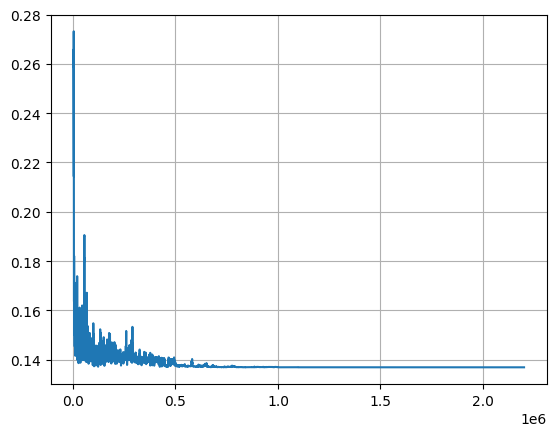

b desired [0.   0.02 0.14 0.01 0.06 0.   0.   0.69 0.   0.08]
b found [0.000e+00 1.000e-04 3.100e-03 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 5.531e-01 0.000e+00 0.000e+00]

difference [0.     0.0199 0.1369 0.0099 0.06   0.     0.     0.1369 0.     0.08  ]
Sup Norm is 0.13692356558651197
L2 norm is 0.21906319511082897

best_phi [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.407 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.004 0.    0.    0.    0.584 0.    0.    0.
 0.    0.005 0.    0.   ]


In [7]:
counter, error_values, best_phi, b_found, score = montecarlo(A_matrix.T, b_array)

In [8]:
b_found/np.sum(b_found)


array([0.00000000e+00, 9.13986818e-05, 5.53027221e-03, 1.02744947e-04,
       6.38497585e-05, 0.00000000e+00, 0.00000000e+00, 9.94211733e-01,
       0.00000000e+00, 1.21554519e-09])

In [9]:
0.00   + 0.02 +   0.14 +   0.01 + 0.06 +   0. +   0.+    0.86+ 0. +   0.08

1.1700000000000002

### Finding all Vertices using Motzkin

In [10]:
# Finding Sup Norm
A_ub, b_ub = linear_reformulation(A_matrix.T,b_array)


In [11]:
def optimized_linear_reformulation(A, b, epsilon=1e-9):
    """
    Optimized reformulation with techniques to make CDD more likely to succeed
    """
    print(f"Original dimensions: A is {A.shape}, b is {len(b)}")
    
    # 1. Identify and fix zero variables
    # Variables that are very likely to be zero in the solution
    col_sums = np.sum(np.abs(A), axis=0)
    zero_threshold = np.percentile(col_sums, 5)  # bottom 25% of columns by "importance"
    likely_zero_cols = col_sums <= zero_threshold
    
    # Keep track of which columns we're keeping and their original indices
    keep_cols = ~likely_zero_cols
    column_map = np.arange(A.shape[1])[keep_cols]
    A_reduced = A[:, keep_cols]
    
    print(f"Fixed {np.sum(likely_zero_cols)} variables to zero, reducing dimensions")
    
    # 2. Process constraints efficiently
    A_ub = np.hstack([A_reduced, np.zeros((A_reduced.shape[0], 1))])  # Add column for t
    neg_A_ub = np.hstack([-A_reduced, -np.ones((A_reduced.shape[0], 1))])  # -A and -1s for t
    
    # 3. Advanced redundancy elimination - only keep constraints that are "tight"
    # For each row in A, calculate how much it restricts the feasible space
    A_ub_all = np.vstack([A_ub, neg_A_ub])
    b_ub_all = np.hstack([b, -b])
    
    # 4. Remove numerically similar constraints
    # Round to detect nearly identical constraints
    precision_decimals = -int(np.log10(epsilon))
    rounded = np.round(np.hstack([A_ub_all, b_ub_all.reshape(-1, 1)]), precision_decimals)
    _, unique_indices = np.unique(rounded, axis=0, return_index=True)
    unique_indices = np.sort(unique_indices)
    
    A_ub_final = A_ub_all[unique_indices]
    b_ub_final = b_ub_all[unique_indices]
    
    # 5. Scale constraints to improve numerical stability
    row_norms = np.maximum(np.linalg.norm(A_ub_final, axis=1), 1e-10)
    A_ub_final = A_ub_final / row_norms[:, np.newaxis]
    b_ub_final = b_ub_final / row_norms
    
    print(f"Final dimensions: A_ub is {A_ub_final.shape}, b_ub is {len(b_ub_final)}")
    
    return A_ub_final, b_ub_final, column_map

In [12]:
def efficient_vertexcddlist2(A_ub, b_ub):
    """More efficient vertex enumeration using CDD with optimizations"""
    # Create inequality representation
    array = np.hstack((b_ub.reshape(-1, 1), -A_ub))
    
    # Set CDD options for better performance
    # 1. Use the default double description method
    # 2. Change adjacency rule to maximize performance
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    
    # This is important: Tell CDD you're only interested in vertices
    mat.representation = cdd.Representation.INEQUALITY
    mat.default_redundant_points = False  # Skip redundant point detection
    
    # Construct polyhedron (less verbosely)
    poly = cdd.polyhedron_from_matrix(mat, verbose=False)
    
    # Extract only vertices (not rays)
    gen = cdd.copy_generators(poly)
    vertices = []
    for row in gen.array:
        if row[0] == 1:  # Only include vertices (not rays)
            vertices.append(row[1:])
    
    vertices = np.array(vertices)
    print(f"Found {len(vertices)} vertices")
    
    return vertices

In [13]:
A_ub, b_ub, column_map = optimized_linear_reformulation(A_matrix.T, b_array)


Original dimensions: A is (10, 40), b is 10
Fixed 2 variables to zero, reducing dimensions
Final dimensions: A_ub is (20, 39), b_ub is 20


In [14]:
def basic_vertexcddlist2(A_ub, b_ub):
    """Most basic CDD vertex enumeration with no extra options"""
    # Create inequality representation
    array = np.hstack((b_ub.reshape(-1, 1), -A_ub))
    
    # Create matrix
    mat = cdd.matrix_from_array(array, rep_type=cdd.RepType.INEQUALITY)
    
    # Construct polyhedron
    poly = cdd.polyhedron_from_matrix(mat)
    
    # Extract generators
    gen = cdd.copy_generators(poly)
    
    # Convert to numpy array and ignore the first column (homogenizing column)
    solutions = np.array(gen.array)
    solutions = solutions[:, 1:]  # Ignore the first column
    
    print(f"Found {solutions.shape[0]} vertices")
    
    return solutions

In [15]:
#A_ub, b_ub, column_map = optimized_linear_reformulation(A_matrix.T, b_array)
A_ub, b_ub = linear_reformulation(A_matrix.T, b_array)


In [16]:
solutions2 = vertexcddlist2(A_ub, b_ub)


Vertex Walk Complete
Vertices found: 4932     Dimension of vertex 40


In [17]:
best_vertices2, best_sup_norm2 = find_supnorm_vertices2(A_ub,b_ub,solutions2)


Sup norm 0.1280012405175021
number of best points 1
Example of Best Vertex [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.97990158 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02009842 0.         0.        ]
Number of active constraints 58
Sum of example phi 1.0000000000000002


In [19]:
# Finding all vertices with the same sup norm

print('b_desired:', b_array)
for vertex in best_vertices2:
    b_found = A_matrix.T@vertex[:30]
    L1_norm = np.sum(b_array-b_found)
    L2_norm = (np.sum((b_array-b_found)**2))**0.5
    sup_norm = np.max(b_array-b_found)
    print('b found' , np.round(b_found,3), '  L1 Norm:', np.round(L1_norm,4) , '  L2 Norm:', np.round(L2_norm,4), 'Sup Norm', np.round(sup_norm,4)  )

print()
print('Now checking if the average has the same sup norm')
print()
avg_vertex = np.mean(best_vertices2, axis=0)
avg_vertex[:30]
b_found = A_matrix.T@avg_vertex[:30]
L1_norm = np.sum(b_array-b_found)
L2_norm = (np.sum((b_array-b_found)**2))**0.5
sup_norm = np.max(b_array-b_found)
print('Average b' , np.round(b_found,3), '  L1 Norm:', np.round(L1_norm,4) , '  L2 Norm:', np.round(L2_norm,4), '  Sup Norm', np.round(sup_norm,4)  )

print()
print('Sup Norm', np.round(sup_norm,6))


b_desired: [0.   0.02 0.14 0.01 0.06 0.   0.   0.69 0.   0.08]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 30 is different from 40)

### Adding some small tolerance

In [20]:
best_vertices3, best_sup_norm3 = find_supnorm_vertices3(A_ub,b_ub,solutions2)


Sup norm 0.1280012405175021
number of best points 1
Example of Best Vertex [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.97990158 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02009842 0.         0.        ]
Number of active constraints 58
Sum of example phi 1.0000000000000002


In [ ]:
# Finding all vertices with the same sup norm

print('A list of all b_founds from all vertices found')
for vertex in best_vertices3:
    b_found = A_matrix.T@vertex[:30]
    L1_norm = np.sum(b_array-b_found)
    L2_norm = (np.sum((b_array-b_found)**2))**0.5
    sup_norm = np.max(b_array-b_found)
    print('b found' , np.round(b_found,3), '  L1 Norm:', np.round(L1_norm,4) , '  L2 Norm:', np.round(L2_norm,4), '  Sup Norm:', np.round(sup_norm,4)  )

print()
print('Now checking if the average has the same sup norm')
print()
avg_vertex3 = np.mean(best_vertices2, axis=0)
avg_vertex[:30]
b_found = A_matrix.T@avg_vertex[:30]
L1_norm = np.sum(b_array-b_found)
L2_norm = (np.sum((b_array-b_found)**2))**0.5
sup_norm = np.max(b_array-b_found)
print('b found:' , np.round(b_found,3), '  L1 Norm:', np.round(L1_norm,4) , '  L2 Norm:', np.round(L2_norm,4), '  Sup Norm:', np.round(sup_norm,4)  )
print()
print('Sup Norm', np.round(sup_norm,6))


### Process 4 -  Algorithm 2

### 3.1.1 Algorithm 2

Version 1 - Using the Average Vertex


#### Algorithm 2 as presented

**Initialize**:
- M* <-- 2
- v' <-- 0
- {v'} is empty

**Begin vertex walk**:
- **Repeat**:
  1. Generate next vertex v'
  2. Compute vector sample L <-- F^T v'
  3. Find M*

  - If M* strictly decreased:
    - Empty {v'}
    - Remember new minimum M* value
    - Restart collection with v'

  - If M* did not change:
    - Add v' to {v'} collection

  - If M* strictly increased:
    - Do nothing

  - Vertex walk to next v' vertex

- **Until** v' = 0

**Monte Carlo Sampling**:
- Choose a large integer N.
- Transform link certitudes f_{i,j} into distribution functions, F_{i,j}, for each link Φ_i → L_j.

- **Repeat** N times:
  1. Select phi~ as the average of all vertices
  3. Make random selections for each f_{i,j} based on certitude functions.
  4. Compute observed L~ = F^T *Phi~* and add to histogram.

- **End Repeat**

- Normalize the resulting raw histogram to unit area.


In [ ]:
b_all = []
for _ in range(0, 5_000):
    F_sampled = sample_from_F_matrix(F_matrix)
    b_for_hist = F_sampled.T @ avg_vertex3[:30]
    b_all.append(b_for_hist)

# Transpose b_all to have each row represent values for a specific b
b_all = np.array(b_all).T  

# Plot histograms for each b value with different colors
num_b_values = b_all.shape[0]  # Get the number of b values
colors = plt.cm.viridis(np.linspace(0, 1, num_b_values))  # Generate distinct colors

for i in range(num_b_values):
    hist, bins = np.histogram(b_all[i], bins=50)  # Get histogram data
    hist_normalized = hist / hist.sum()  # Normalize the histogram
    plt.bar(bins[:-1], hist_normalized, width=bins[1] - bins[0], alpha=0.5, color=colors[i], label=f'label_{i}')

plt.xlabel('b values')
plt.xlim([0, 0.5])
plt.ylim([0, 0.08])
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of b values')
plt.legend()
plt.show()

In [ ]:
b_all1=b_all
np.mean(b_all1,axis=1)

#### Algorithm 2 as presented

**Initialize**:
- M* <-- 2
- v' <-- 0
- {v'} is empty

**Begin vertex walk**:
- **Repeat**:
  1. Generate next vertex v'
  2. Compute vector sample L <-- F^T v'
  3. Find M*

  - If M* strictly decreased:
    - Empty {v'}
    - Remember new minimum M* value
    - Restart collection with v'

  - If M* did not change:
    - Add v' to {v'} collection

  - If M* strictly increased:
    - Do nothing

  - Vertex walk to next v' vertex

- **Until** v' = 0

**Monte Carlo Sampling**:
- Choose a large integer N.
- Transform link certitudes f_{i,j} into distribution functions, F_{i,j}, for each link Φ_i → L_j.

- **Repeat** N times:
  1. Select the values of the weights λ_k uniformly, randomly: P_{λ_k} = 1, λ_k ≥ 0.
  2. Form a solution vector phi~ = ∑_{v'} λ_k v'.
  3. Make random selections for each f_{i,j} based on certitude functions.
  4. Compute observed L~ = F^T *Phi~* and add to histogram.

- **End Repeat**

- Normalize the resulting raw histogram to unit area.


In [ ]:
import numpy as np

def sample_from_best_vertices3(best_vertices):
    """
    Samples a vertex from best_vertices (excluding the last element of 
    each vertex) with random weights that sum to 1.

    Args:
      best_vertices: A NumPy array of vertices.

    Returns:
      A NumPy array representing the sampled vertex with weights.
    """
    # Remove the last element from each vertex
    best_vertices_trimmed = best_vertices[:, :-1]  

    num_vertices = len(best_vertices_trimmed)
    weights = np.zeros(num_vertices)
    remaining_weight = 1.0
    available_indices = list(range(num_vertices))

    for _ in range(num_vertices - 1):
        index = np.random.choice(available_indices)
        available_indices.remove(index)
        weight = np.random.uniform(0, remaining_weight)
        weights[index] = weight
        remaining_weight -= weight

    weights[available_indices[0]] = remaining_weight

    # Calculate the weighted average using the trimmed vertices
    sampled_vertex = np.sum(best_vertices_trimmed * weights[:, np.newaxis], axis=0)  
    return sampled_vertex


# Example usage:
# Assuming you have best_vertices3 from your previous code
sampled_vertex = sample_from_best_vertices3(best_vertices3)
print(np.round(sampled_vertex,3))

In [ ]:
b_all = []
for _ in range(0, 5_000):
    F_sampled = sample_from_F_matrix(F_matrix)
    sampled_vertex = sample_from_best_vertices3(best_vertices3)
    b_for_hist = F_sampled.T @ sampled_vertex[:30]
    b_all.append(b_for_hist)

# Transpose b_all to have each row represent values for a specific b
b_all = np.array(b_all).T  

# Plot histograms for each b value with different colors
num_b_values = b_all.shape[0]  # Get the number of b values
colors = plt.cm.viridis(np.linspace(0, 1, num_b_values))  # Generate distinct colors

for i in range(num_b_values):
    hist, bins = np.histogram(b_all[i], bins=50)  # Get histogram data
    hist_normalized = hist / hist.sum()  # Normalize the histogram
    plt.bar(bins[:-1], hist_normalized, width=bins[1] - bins[0], alpha=0.5, color=colors[i], label=f'label_{i}')

plt.xlabel('b values')
plt.xlim([0, 0.5])
plt.ylim([0, 0.1])
plt.ylabel('Normalized Frequency')
plt.title('Normalized Histogram of b values')
plt.legend()
plt.show()

In [ ]:
b_all2=b_all
print(' Sampling between vertices')
print(np.round(np.mean(b_all2,axis=1),3))

In [ ]:
print('Choosing average vertex')

print(np.round(np.mean(b_all1,axis=1),3))

### 3.1.2 Rewritten for easier understanding

- **Initialize**:
  - **L** = []
  - **Φ** = []
  - A = very large number
  - B = very large number

- **Input** $ \hat{L} $

- **Loop A times**:
  1. Sample $ F $ to create $ \hat{F} $.
  2. Solve $ \hat{F} \hat{\Phi} = \hat{L} $ for $ \hat{\Phi} $. (Find all phi's)
  3. Append $ \hat{\Phi} $ to **Φ**.

- **Loop B times**:
  1. Sample $ F $ to create $ \tilde{F} $.
  2. Sample **Φ** to create $ \tilde{\Phi} $.
  3. Solve $ \tilde{L} = \tilde{F} \tilde{\Phi} $ for $ \tilde{L} $.
  4. Append $ \tilde{L} $ to **L**.

- **Create a normalized histogram** of **L**.
- **Create a normalized histogram** of **Φ**.
